### Ideas

- Normalisization based on training dataset statistics (mean & std)
- How to deal with no data part? 
    - Including for the normalization

In [367]:
import rasterio
from rasterio import features
import pandas as pd 
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import re
from shapely import wkt
plt.rcParams['figure.figsize'] = [15,15]

FILENAME_PATTERN = re.compile('SN6_Train_AOI_11_Rotterdam_SAR-Intensity_(\d*_\d*_tile_\d*).tif')

In [361]:
def preprocess_to_display(x, n_channels, normalize=True):
    preprocessed = x.copy()
    if normalize:
        preprocessed = preprocessed/preprocessed.max()
    if n_channels > 1:
        preprocessed = np.moveaxis(preprocessed[:3], 0, -1)
    else: 
        preprocessed = preprocessed[0]
    return preprocessed

def get_sar_imagery_statistics(path):
    array = get_array_from_tiff(path)
    means = array.mean(axis=(1,2))
    stds = array.std(axis=(1,2))
    return means, stds

def get_array_from_tiff(path):
    with rasterio.open(path) as file: 
        im = file.read()
    return im

def get_id_from_filename(filename):
    return FILENAME_PATTERN.match(filename)[1]

def get_polygons_in_image(rstr_filename):
    image_id = get_id_from_filename(rstr_filename)
    return buildings.loc[buildings['ImageId']==image_id,'PolygonWKT_Pix']

In [273]:
common_path = Path('train/AOI_11_Rotterdam')
sar_path = common_path/'SAR-Intensity'

In [41]:
!ls train/AOI_11_Rotterdam

PAN               PS-RGBNIR         SAR-Intensity     geojson_buildings
PS-RGB            RGBNIR            SummaryData


### Metadata

In [57]:
!ls train/AOI_11_Rotterdam/SummaryData/

SAR_orientations.txt
SN6_Train_AOI_11_Rotterdam_Buildings.csv


In [55]:
pd.read_csv(common_path/'SummaryData/SAR_orientations.txt',sep=' ')

,20190804111224_20190804111453,1
0,20190804111851_20190804112030,0
1,20190804113009_20190804113242,1
2,20190804113605_20190804113825,0
3,20190804114132_20190804114404,1
4,20190804114647_20190804114904,0
...,...,...
198,20190823160351_20190823160645,1
199,20190823160819_20190823161113,0
200,20190823161251_20190823161546,1
201,20190823161806_20190823162129,0


In [241]:
buildings = pd.read_csv(common_path/'SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv',engine='python')
buildings

,ImageId,TileBuildingId,PolygonWKT_Pix,Mean_Building_Height,Median_Building_Height,StdDev_Building_Height
0,20190822070610_20190822070846_tile_3721,0,"POLYGON ((299.6396801332012 349.3765436094254,...",9.962397,9.96,0.006495
1,20190822070610_20190822070846_tile_3721,1,"POLYGON ((115.5360228798818 339.845588516444, ...",2.810000,2.81,0.000000
2,20190822070610_20190822070846_tile_3721,2,"POLYGON ((768.9086768317502 329.8960437048227,...",14.420000,14.42,0.000000
3,20190822070610_20190822070846_tile_3721,3,"POLYGON ((755.8174585120287 330.0953964963555,...",14.420000,14.42,0.000000
4,20190822070610_20190822070846_tile_3721,4,"POLYGON ((392.8786215754226 335.6222213506699,...",8.590000,8.59,0.000000
...,...,...,...,...,...,...
214677,20190822133333_20190822133635_tile_7758,5,"POLYGON ((241.8162563492078 165.4673625379801,...",5.970000,5.97,0.000000
214678,20190822133333_20190822133635_tile_7758,6,"POLYGON ((431.9838383866008 146.2224273793399,...",10.380000,10.38,0.000000
214679,20190822133333_20190822133635_tile_7758,7,"POLYGON ((128.6518265847117 111.3799640219659,...",3.870000,3.87,0.000000
214680,20190822133333_20190822133635_tile_7758,8,"POLYGON ((415.3016002546065 98.69750475697219,...",11.710000,11.71,0.000000


### Primary quantitative estimations

204

In [358]:
print(f"Number of original images : {len(pd.read_csv(common_path/'SummaryData/SAR_orientations.txt',sep=' ',header=None)[0].unique())}")
print(f"Number of tiles : {len(os.listdir(sar_path))}")
print(f"Shape of tiles: {get_array_from_tiff(sar_path/os.listdir(sar_path)[0]).shape}" )
print(f"Number of building footprints : {len(buildings['ImageId'])}")

Number of original images : 204
Number of tiles : 3401
Shape of tiles: (4, 900, 900)
Number of building footprints : 214682


## Visual inspection

In [251]:
image_id = buildings['ImageId'].sample(1).iloc[0]
im = {}
for ft in filetypes:
    with rasterio.open(common_path/f'{ft}/SN6_Train_AOI_11_Rotterdam_{ft}_{image_id}.tif') as file: 
        im[ft] = file.read()

0
1
2
3
4


(0.0, 1.0, 0.0, 1.0)

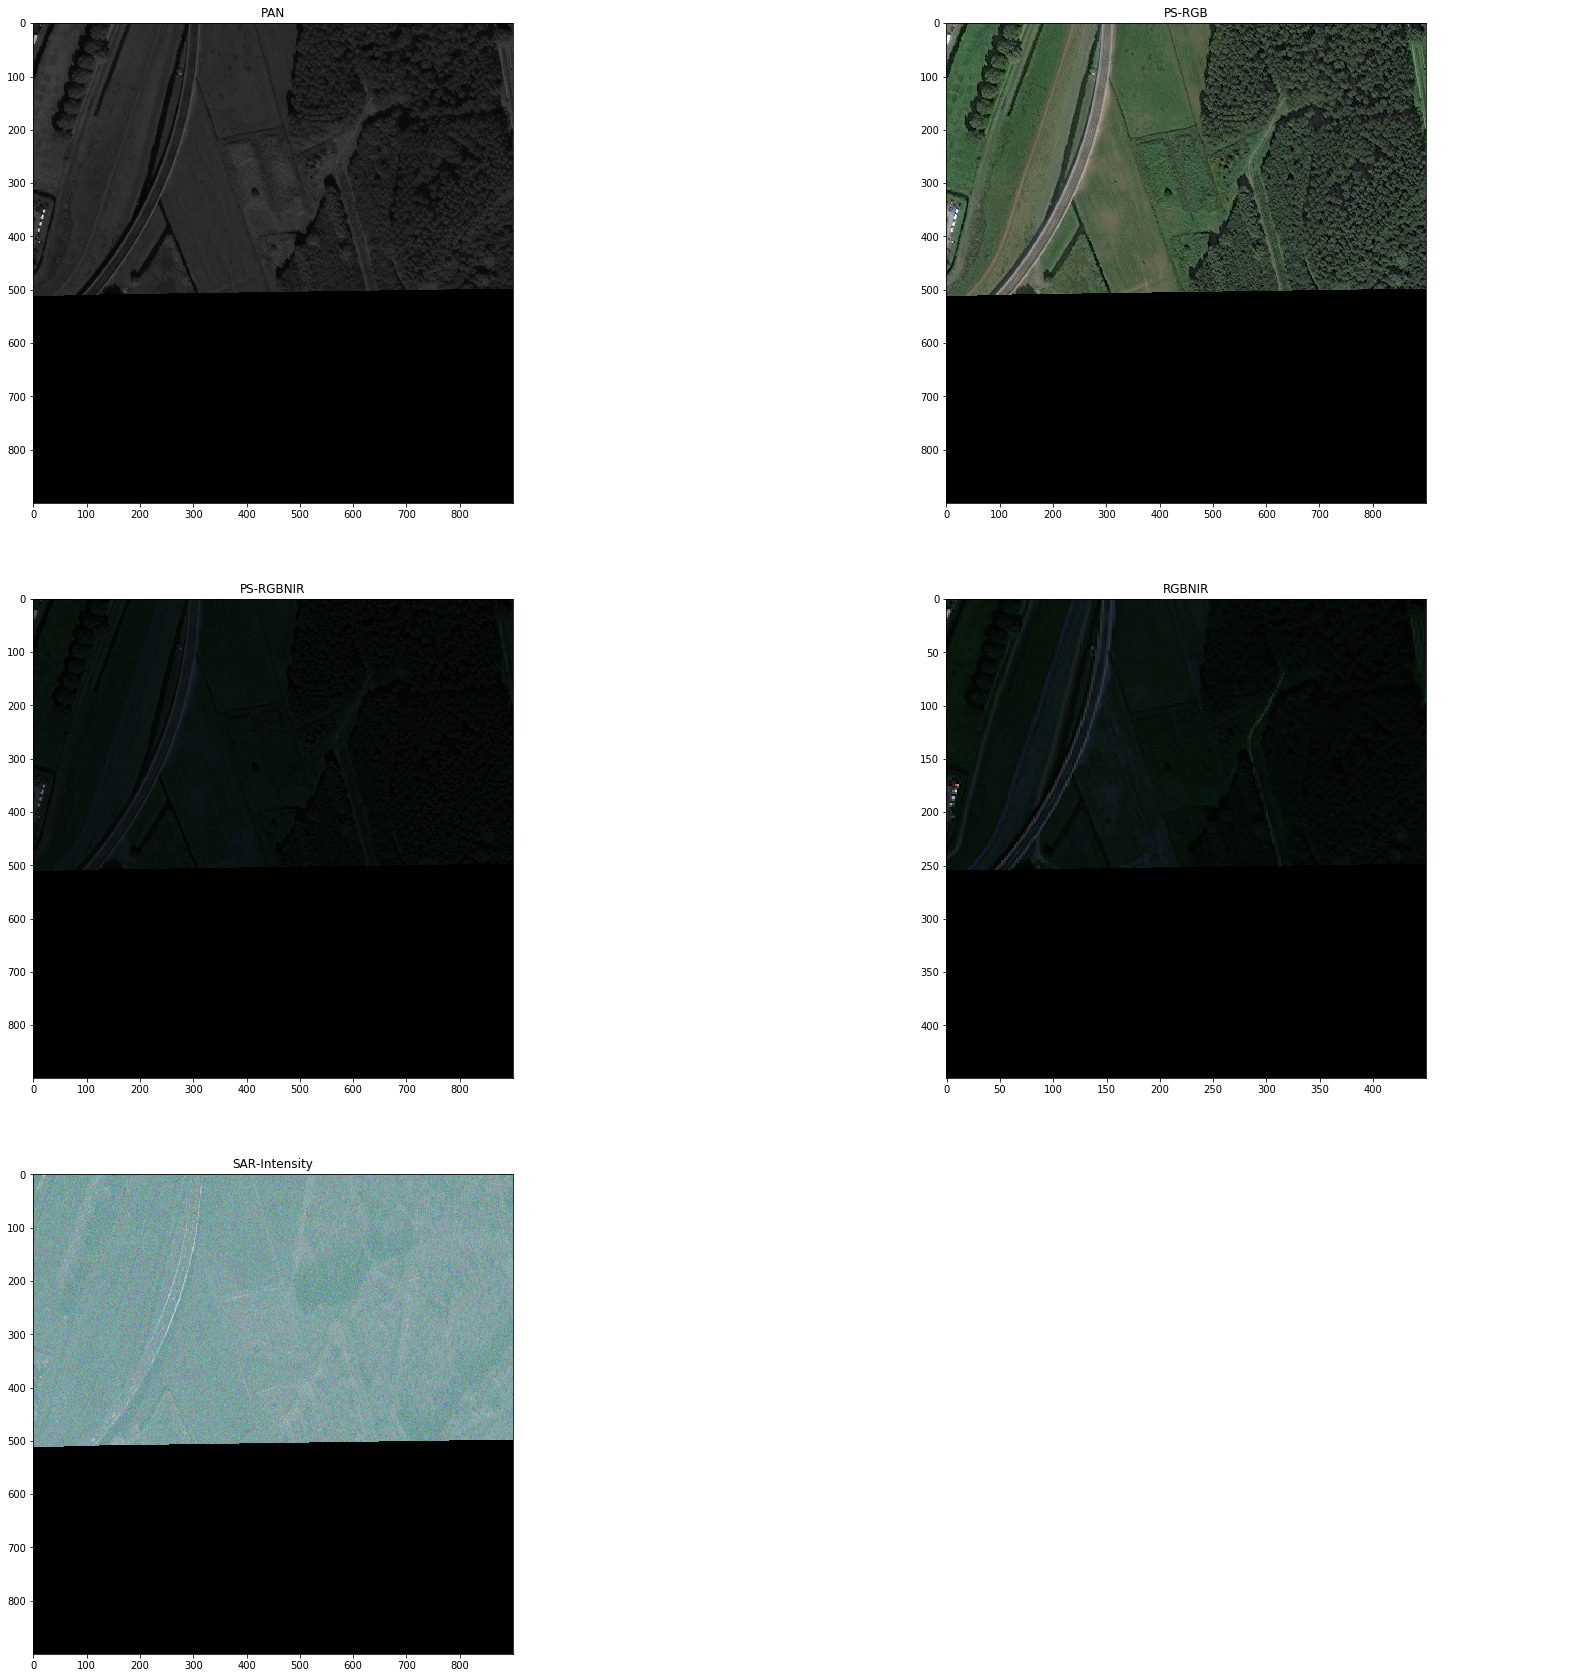

In [253]:
h_sp,w_sp = (1+len(filetypes))//2, 2
fig, ax = plt.subplots(h_sp,w_sp,figsize=[30,30]) 
cmap = None
ax=ax.ravel()
for i,k in enumerate(filetypes):
    print(i)
    image = im[k]
    n_channels = image.shape[0]
    if n_channels == 1:
        cmap = 'gray'
    ax[i].imshow(preprocess_to_display(image,n_channels),cmap=cmap)
    ax[i].set_title(k)
ax[5].axis('off')

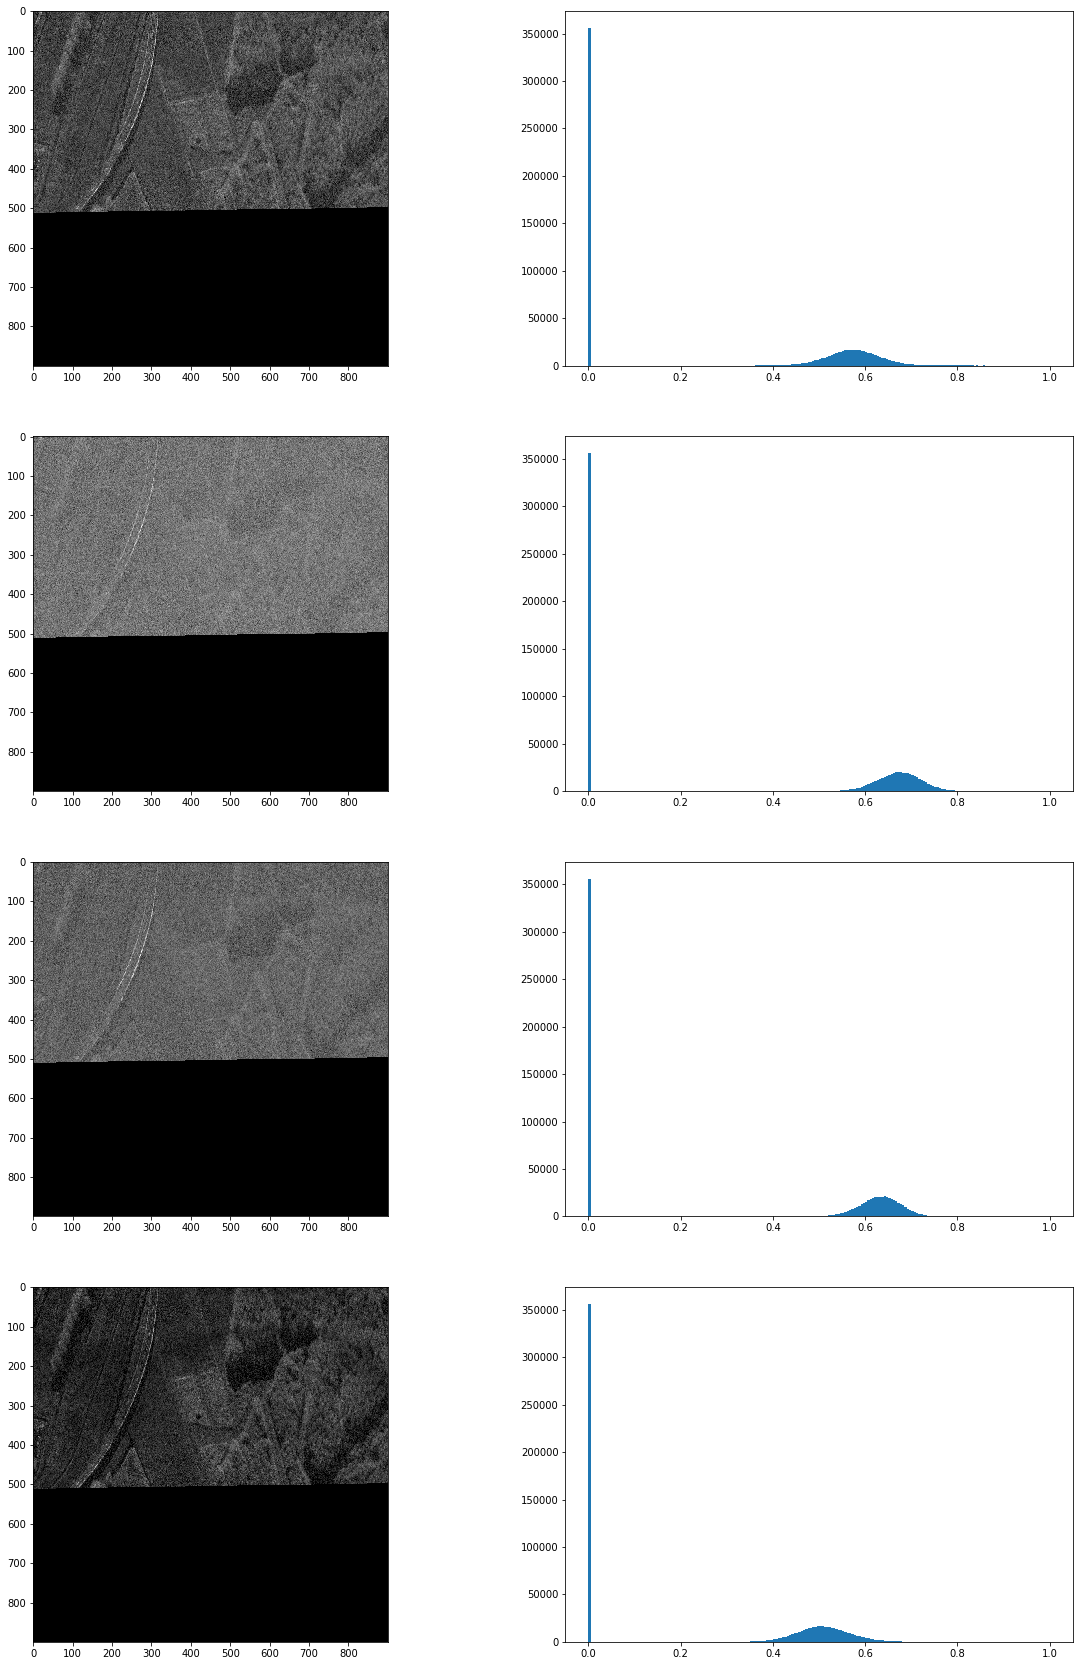

In [295]:
h_sp,w_sp = 4, 2

image = im['SAR-Intensity']
fig, ax = plt.subplots(h_sp,w_sp,figsize=[20,30]) 
cmap = None
ax=ax.ravel()
for i,k in enumerate(range(4)):
    processed_im = preprocess_to_display(np.expand_dims(image[i],0),1)
    ax[2*i].imshow(processed_im,cmap='gray',vmin=0.4, vmax=1)
    ax[2*i+1].hist(processed_im.ravel(), bins=200)

## Statistics

SAR data

In [312]:
import os 
l = list()
for i,p in enumerate(os.listdir(sar_path)):
    if i%100==0: 
        print(i)
        print(sar_path/p)
    l.append(get_sar_imagery_statistics(sar_path/p))

0
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822144546_20190822144829_tile_7590.tif
100
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822091156_20190822091502_tile_120.tif
200
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822100114_20190822100413_tile_669.tif
300
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804124749_20190804125033_tile_3664.tif
400
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075318_20190823075613_tile_5277.tif
500
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161458_20190822161736_tile_8405.tif
600
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822085638_20190822085935_tile_10658.tif
700
train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075755_20190823080053_tile_1076

In [320]:
means = np.array([x[0] for x in l])
stds = np.array([x[1] for x in l]) #TODO compute the real stds not the average of it 

In [327]:
avg = means.mean()
std = stds.mean()

In [329]:
std

15.325681

In [38]:
!ls train/AOI_11_Rotterdam/PS-RGB

SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8681.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8685.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8687.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8689.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8691.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8693.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8695.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111851_20190804112030_tile_5175.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111851_20190804112030_tile_5176.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804113009_20190804113242_tile_4797.tif
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804113009_20190804113242_

## Creation of the ground truth rasters

In [477]:
image_files = os.listdir(sar_path)
polygons = get_polygons_in_image(image_files[0]).to_list()

In [ ]:
def create_raster_ground_truth(image_filename):
    
    polygons = get_polygons_in_image(image_filename).to_list()

    rst = rasterio.open(sar_path/image_filename)
    meta = rst.meta.copy()
    meta.update(compress='lzw')
    
    with rasterio.open(tif_building_path/image_filename, 'w+', **meta) as out:
        out_arr = out.read(1)
        # this is where we create a generator of geom, value pairs to use in rasterizing
        if polygons[0] == 'POLYGON EMPTY':
            burned = out_arr
        else: 
            shapes = ((wkt.loads(geom),100) for geom in polygons)
            burned = features.rasterize(shapes=shapes, fill=0, out=out_arr)
        out.write_band(1, burned)
    return burned

In [ ]:
tif_building_path = common_path/"tif_buildings"

In [494]:
for i,filepath in enumerate(os.listdir(sar_path)):
    if i%100==0:
        print(i)
    create_raster_ground_truth(filepath)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
